# Using Clusters as Features

In [17]:
import numpy as np
import pandas as pd
import time
import csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from io import StringIO
import matplotlib.pyplot as plt


In [19]:

with open('./data/stopwords.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    list1 = list(reader)  
    ENGLISH_STOP_WORDS = list1[0]
    readFile.close()
# added to stop words job	ok	SAP


df = pd.read_csv('./data/training.csv',encoding='latin-1')
df.head()


,Number,Priority,Description,Assignment_group,Assigned_to,State,Created,Closed,Task_type,Subcategory,Close_code,Closure_CI,Cause_Code,CI_Specific_Code,Closed_by,Close_notes,Type
0,INC0697190,4 - Low (Resolution SLA ? 5 Business days),(CI=SAP BW(Business Warehouse))Redwood PRD: Jo...,SAP BW Support,Suganya Balasubramani (sbalasu),Closed,8/1/2017 15:04,8/1/2017 18:47,Incident,ERP Misc,Solved (Permanently),SAP BW(Business Warehouse),Job Failure,Job: Failure alert delay,Suganya Balasubramani (sbalasu),ISSUE:ZRET_SNAP_T_D_F is failed.\nRCA:Due to b...,2
1,INC0697200,4 - Low (Resolution SLA ? 5 Business days),"(CI=SAP HCM (Human Capital Management))Job ""ZH...",SAP HR/PY Support,Swathi Naru (snaru),Closed,8/1/2017 15:39,8/3/2017 15:11,Incident,HR ERP,Solved (Permanently),SAP HCM (Human Capital Management),Job Failure,Job: Definition,Swathi Naru (snaru),issue:(CI=SAP HCM (Human Capital Management))J...,2
2,INC0697212,4 - Low (Resolution SLA ? 5 Business days),(CI=SAP BPC NW EPM (Product & Cust Eng - PCE))...,SAP BPC Support,Firoze Shaik (fishaik),Closed,8/1/2017 17:02,8/3/2017 16:23,Incident,"Planning, Budgeting, Forecasting",Solved (Permanently),SAP BPC NW (Business Planning and Consolidation),Job Failure,Job: Connection Issue,Suganya Balasubramani (sbalasu),ISsue:(CI=SAP BPC NW EPM (Product & Cust Eng -...,2
3,INC0697213,4 - Low (Resolution SLA ? 5 Business days),(CI=SAP BPC NW EPM (Project Base Accounting - ...,SAP BPC Support,Firoze Shaik (fishaik),Closed,8/1/2017 17:02,8/3/2017 16:11,Incident,"Planning, Budgeting, Forecasting",Solved (Permanently),SAP BPC NW (Business Planning and Consolidation),Job Failure,Incorrect/Missing Data,Suganya Balasubramani (sbalasu),ISsue:(CI=SAP BPC NW EPM (Project Base Account...,2
4,INC0697369,4 - Low (Resolution SLA ? 5 Business days),(CI=SAP ERP FI (Finance))JC_ZFICO_B_AR_DLY_ATL...,SAP SD Support,Rajender reddy Baradi (rbaradi),Closed,8/2/2017 7:36,8/3/2017 10:38,Incident,Business Service,Duplicate,SAP ERP SD (Sales and Distribution),Job Failure,Job Stuck/Error,Rajender reddy Baradi (rbaradi),issue:(CI=SAP ERP FI (Finance))JC_ZFICO_B_AR_D...,2


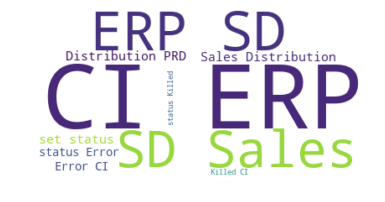

In [170]:

#from nltk.corpus import stopwords
SAP_SD_Support = " ".join(review for review in df[df["Assignment_group"]=="SAP SD Support"].Description)



cloud = WordCloud(background_color="white", max_words=10, stopwords=ENGLISH_STOP_WORDS)

#positive_cloud = cloud.generate(df.loc[df.Assignment_group == 'SAP SD Support'].str.cat(sep='\n'))
positive_cloud = cloud.generate(SAP_SD_Support)
plt.figure()
plt.imshow(positive_cloud)
plt.imshow(positive_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)
def remove_special_char(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<')
    return re.sub(clean, '', text)

In [21]:
df = df[pd.notnull(df['Description'])]

for index,row in df.iterrows():
    row['Description'] = remove_html_tags(row['Description'])
  #  row['Description'] = remove_special_char(row['Description'])

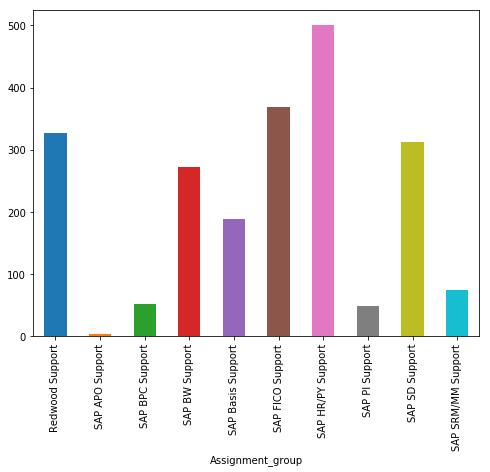

In [173]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Assignment_group').Description.count().plot.bar(ylim=0)
plt.show()

In [7]:
df['category_id'] = df['Assignment_group'].factorize()[0]
category_id_df = df[['Assignment_group', 'category_id']].drop_duplicates().sort_values('category_id')
#category_id_df.columns.values 
category_id_df

,Assignment_group,category_id
0,SAP BW Support,0
1,SAP HR/PY Support,1
2,SAP BPC Support,2
4,SAP SD Support,3
14,Redwood Support,4
23,SAP FICO Support,5
47,SAP Basis Support,6
63,SAP SRM/MM Support,7
318,SAP PI Support,8
711,SAP APO Support,9


In [8]:
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Assignment_group']].values)
id_to_category

{0: 'SAP BW Support',
 1: 'SAP HR/PY Support',
 2: 'SAP BPC Support',
 3: 'SAP SD Support',
 4: 'Redwood Support',
 5: 'SAP FICO Support',
 6: 'SAP Basis Support',
 7: 'SAP SRM/MM Support',
 8: 'SAP PI Support',
 9: 'SAP APO Support'}

In [9]:
tfidf = TfidfVectorizer(input='content', encoding='utf-8',
                 decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None,
                 tokenizer=None, analyzer='word', stop_words=ENGLISH_STOP_WORDS,
                 token_pattern=r"(?u)\b\w\w+\b",
                 ngram_range=(1, 2), max_df=0.5, min_df=0.01,
                 max_features=None, vocabulary=None, binary=False, 
                 dtype=np.int64, norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
features = tfidf.fit_transform(df.Description).toarray()
labels = df.category_id
features.shape

(2147, 171)

In [177]:
N = 2
for Assignment_group, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Assignment_group))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Redwood Support':
  . Most correlated unigrams:
       . netweaver
       . integration
  . Most correlated bigrams:
       . integration redwood
       . redwood ended
# 'SAP APO Support':
  . Most correlated unigrams:
       . prd
       . redwood
  . Most correlated bigrams:
       . ended status
       . redwood prd
# 'SAP BPC Support':
  . Most correlated unigrams:
       . nw
       . bpc
  . Most correlated bigrams:
       . nw epm
       . bpc nw
# 'SAP BW Support':
  . Most correlated unigrams:
       . business
       . bw
  . Most correlated bigrams:
       . sap bw
       . bw business
# 'SAP Basis Support':
  . Most correlated unigrams:
       . bw
       . zfico_e1_ap_dly_prb2b102d_non_sap_atlut
  . Most correlated bigrams:
       . prd ended
       . finance zfico_e1_ap_dly_prb2b102d_non_sap_atlut
# 'SAP FICO Support':
  . Most correlated unigrams:
       . finance
       . fi
  . Most correlated bigrams:
       . fi finance
       . erp fi
# 'SAP HR/PY Support':
  . 

In [10]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

In [11]:
class clust():
    def _load_data(self, df):
        data = df
        X = df['Description']
        Y = df['Assignment_group']
        tfidf_vectorizer = TfidfVectorizer(input='content', encoding='utf-8',
                 decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None,
                 tokenizer=None, analyzer='word', stop_words=ENGLISH_STOP_WORDS,
                 token_pattern=r"(?u)\b\w\w+\b",
                 ngram_range=(1, 2), max_df=0.5, min_df=0.01,
                 max_features=None, vocabulary=None, binary=False, 
                 dtype=np.int64, norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
        X_tfidf = tfidf_vectorizer.fit_transform(X)
        joblib.dump(tfidf_vectorizer, 'tfidf.pkl') 
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X_tfidf, Y, test_size=0.1, random_state=42)
        
    def __init__(self, df):
        self._load_data(df)
    
    @timeit
    def classify(self, model=LogisticRegression(random_state=42)):
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        print('Accuracy: {}'.format(accuracy_score(self.y_test, y_pred)))
        return model

    @timeit
    def Kmeans(self, output='add'):
        n_clusters = len(np.unique(self.y_train))
        clf = KMeans(n_clusters = n_clusters, random_state=42)
        clf.fit(self.X_train)
        y_labels_train = clf.labels_
        y_labels_test = clf.predict(self.X_test)
        if output == 'add':
            self.X_train['km_clust'] = y_labels_train
            self.X_test['km_clust'] = y_labels_test
        elif output == 'replace':
            self.X_train = y_labels_train[:, np.newaxis]
            self.X_test = y_labels_test[:, np.newaxis]
        else:
            raise ValueError('output should be either add or replace')
        return self

In [180]:
clust(df).Kmeans(output='replace').classify(model=SVC())

'Kmeans'  800.05 ms
Accuracy: 0.7767441860465116
'classify'  27.00 ms


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [86]:
clust(df).Kmeans(output='replace').classify()

'Kmeans'  845.00 ms
Accuracy: 0.18604651162790697
'classify'  13.00 ms


In [87]:
clust(df).Kmeans(output='replace').classify(model=RandomForestClassifier(n_estimators=300, max_depth=5, random_state=0))

'Kmeans'  823.00 ms
Accuracy: 0.7348837209302326
'classify'  735.00 ms


In [88]:
clust(df).Kmeans(output='replace').classify(model=MultinomialNB())

'Kmeans'  825.00 ms
Accuracy: 0.2
'classify'  48.00 ms


In [89]:
clust(df).classify(model=MultinomialNB())

Accuracy: 0.813953488372093
'classify'  29.00 ms


In [90]:
clust(df).classify()

Accuracy: 0.8186046511627907
'classify'  53.00 ms


In [91]:
clust(df).classify(model=RandomForestClassifier(n_estimators=300, max_depth=5, random_state=0))

Accuracy: 0.813953488372093
'classify'  692.00 ms


In [181]:
clf = clust(df).classify(model=SVC())

Accuracy: 0.7302325581395349
'classify'  255.01 ms


In [182]:
from sklearn.externals import joblib
joblib.dump(clf, 'model.pkl')

['model.pkl']

In [135]:
df = df[:10]

In [136]:
incident_numbers = df['Number']
descr_df = df[pd.notnull(df['Description'])]

for index,row in descr_df.iterrows():
    row['Description'] = remove_html_tags(row['Description'])
descr_df = descr_df['Description']
#descr_df = [descr_df]
descr_df = [str(x) for x in list(descr_df)]
pred_assignment_groups = []

In [140]:
list(incident_numbers)

['INC0697190',
 'INC0697200',
 'INC0697212',
 'INC0697213',
 'INC0697369',
 'INC0697370',
 'INC0697423',
 'INC0697424',
 'INC0697425',
 'INC0697459']

In [137]:
descr_df

['(CI=SAP BW(Business Warehouse))Redwood PRD: Job Ended Not OK.',
 '(CI=SAP HCM (Human Capital Management))Job "ZHCM_WW_CYC_Load_WWHRDB_Hourly_Data_To_HRETL_Database_NUS"  (47120848) ended with status Error',
 '(CI=SAP BPC NW EPM (Product & Cust Eng - PCE))ATL Redwood PRD: BPC Redwood Job ZPC_CCR_INT Ended Not Ok.',
 '(CI=SAP BPC NW EPM (Project Base Accounting - PBA))ATL Redwood PRD: BPC Redwood Job ZPC_PBA_MD Ended Not Ok.',
 '(CI=SAP ERP FI (Finance))JC_ZFICO_B_AR_DLY_ATLUT (47110773) ended with status Error',
 '(CI=SAP ERP FI (Finance))ZFICO_B1_AR_DLY_PRars118D_SAP (47110775) ended with status Killed',
 '(CI=SAP HCM (Human Capital Management))ZHCM_OM_DLY_Remove_Roles_From_Chiefs_Automating_Chief_Roles_NUS (47118572) ended with status Killed',
 '(CI=SAP HCM (Human Capital Management))JC_ZHCM_OM_DLY_Automating_Roles_NUS (47118568) ended with status Error',
 '(CI=SAP HCM (Human Capital Management))JC_ZHCM_OM_DLY_Automating_Chief_Roles_NUS (47118561) ended with status Error',
 '(CI=SAP

In [165]:
fittedModel = joblib.load('./models/RandomForestClassifier.pkl')
tfidf1 = joblib.load('./data/tfidf.pkl') 
#print(clf.predict(tfidf1.fit_transform([df.Description[0]]).toarray()))
            #for i in descr_df:
pred_assignment_groups = fittedModel.predict(tfidf1.transform(descr_df).toarray())

In [166]:
pred_assignment_groups

array(['SAP BW Support', 'SAP HR/PY Support', 'SAP BPC Support',
       'SAP BPC Support', 'SAP FICO Support', 'SAP FICO Support',
       'SAP HR/PY Support', 'SAP HR/PY Support', 'SAP HR/PY Support',
       'SAP HR/PY Support'], dtype=object)

In [168]:
final_predictions =  pd.DataFrame(pred_assignment_groups)

In [175]:
final_predictions = pd.DataFrame({'assignment_groups':pred_assignment_groups,'Numbers' : incident_numbers})

In [153]:
final_predictions['Numbers'] = incident_numbers

In [176]:
final_predictions

,assignment_groups,Numbers
0,SAP BW Support,INC0697190
1,SAP HR/PY Support,INC0697200
2,SAP BPC Support,INC0697212
3,SAP BPC Support,INC0697213
4,SAP FICO Support,INC0697369
5,SAP FICO Support,INC0697370
6,SAP HR/PY Support,INC0697423
7,SAP HR/PY Support,INC0697424
8,SAP HR/PY Support,INC0697425
9,SAP HR/PY Support,INC0697459


In [121]:
descr_df = df[pd.notnull(df['Description'])]
incident_ids = df['Number']
for index,row in descr_df.iterrows():
            row['Description'] = remove_html_tags(row['Description'])

In [122]:
descr_df

,Number,Priority,Description,Assignment_group,Assigned_to,State,Created,Closed,Task_type,Subcategory,Close_code,Closure_CI,Cause_Code,CI_Specific_Code,Closed_by,Close_notes,Type
0,INC0697190,4 - Low (Resolution SLA ? 5 Business days),(CI=SAP BW(Business Warehouse))Redwood PRD: Jo...,SAP BW Support,Suganya Balasubramani (sbalasu),Closed,8/1/2017 15:04,8/1/2017 18:47,Incident,ERP Misc,Solved (Permanently),SAP BW(Business Warehouse),Job Failure,Job: Failure alert delay,Suganya Balasubramani (sbalasu),ISSUE:ZRET_SNAP_T_D_F is failed.\nRCA:Due to b...,2
1,INC0697200,4 - Low (Resolution SLA ? 5 Business days),"(CI=SAP HCM (Human Capital Management))Job ""ZH...",SAP HR/PY Support,Swathi Naru (snaru),Closed,8/1/2017 15:39,8/3/2017 15:11,Incident,HR ERP,Solved (Permanently),SAP HCM (Human Capital Management),Job Failure,Job: Definition,Swathi Naru (snaru),issue:(CI=SAP HCM (Human Capital Management))J...,2
2,INC0697212,4 - Low (Resolution SLA ? 5 Business days),(CI=SAP BPC NW EPM (Product & Cust Eng - PCE))...,SAP BPC Support,Firoze Shaik (fishaik),Closed,8/1/2017 17:02,8/3/2017 16:23,Incident,"Planning, Budgeting, Forecasting",Solved (Permanently),SAP BPC NW (Business Planning and Consolidation),Job Failure,Job: Connection Issue,Suganya Balasubramani (sbalasu),ISsue:(CI=SAP BPC NW EPM (Product & Cust Eng -...,2
3,INC0697213,4 - Low (Resolution SLA ? 5 Business days),(CI=SAP BPC NW EPM (Project Base Accounting - ...,SAP BPC Support,Firoze Shaik (fishaik),Closed,8/1/2017 17:02,8/3/2017 16:11,Incident,"Planning, Budgeting, Forecasting",Solved (Permanently),SAP BPC NW (Business Planning and Consolidation),Job Failure,Incorrect/Missing Data,Suganya Balasubramani (sbalasu),ISsue:(CI=SAP BPC NW EPM (Project Base Account...,2
4,INC0697369,4 - Low (Resolution SLA ? 5 Business days),(CI=SAP ERP FI (Finance))JC_ZFICO_B_AR_DLY_ATL...,SAP SD Support,Rajender reddy Baradi (rbaradi),Closed,8/2/2017 7:36,8/3/2017 10:38,Incident,Business Service,Duplicate,SAP ERP SD (Sales and Distribution),Job Failure,Job Stuck/Error,Rajender reddy Baradi (rbaradi),issue:(CI=SAP ERP FI (Finance))JC_ZFICO_B_AR_D...,2
5,INC0697370,4 - Low (Resolution SLA ? 5 Business days),(CI=SAP ERP FI (Finance))ZFICO_B1_AR_DLY_PRars...,SAP SD Support,Harish Munigela (hmunigel),Closed,8/2/2017 7:36,8/3/2017 17:26,Incident,Business Service,Solved (Permanently),SAP ERP SD (Sales and Distribution),Job Failure,Job: Data Error,Harish Munigela (hmunigel),Issue: (CI=SAP ERP FI (Finance))ZFICO_B1_AR_DL...,2
6,INC0697423,4 - Low (Resolution SLA ? 5 Business days),(CI=SAP HCM (Human Capital Management))ZHCM_OM...,SAP HR/PY Support,Pavitra Kanneganti (pkannega),Closed,8/2/2017 12:47,8/2/2017 13:58,Incident,HR ERP,Cancelled,SAP HCM (Human Capital Management),Job Failure,Duplicate,Swathi Naru (snaru),"The redwood job is working fine, there is no...",2
7,INC0697424,4 - Low (Resolution SLA ? 5 Business days),(CI=SAP HCM (Human Capital Management))JC_ZHCM...,SAP HR/PY Support,Swathi Naru (snaru),Closed,8/2/2017 12:47,8/2/2017 14:03,Incident,HR ERP,Cancelled,SAP HCM (Human Capital Management),Job Failure,Duplicate,Swathi Naru (snaru),issue:(CI=SAP HCM (Human Capital Management))J...,2
8,INC0697425,4 - Low (Resolution SLA ? 5 Business days),(CI=SAP HCM (Human Capital Management))JC_ZHCM...,SAP HR/PY Support,Swathi Naru (snaru),Closed,8/2/2017 12:47,8/2/2017 14:00,Incident,HR ERP,Cancelled,SAP HCM (Human Capital Management),Job Failure,Duplicate,Swathi Naru (snaru),issue:(CI=SAP HCM (Human Capital Management))J...,2
9,INC0697459,4 - Low (Resolution SLA ? 5 Business days),(CI=SAP HCM (Human Capital Management))ZHCM_BN...,SAP HR/PY Support,Swathi Naru (snaru),Closed,8/2/2017 15:20,8/7/2017 18:20,Incident,HR ERP,Solved (Permanently),SAP HCM (Human Capital Management),Job Failure,Job: Definition,Swathi Naru (snaru),issue:(CI=SAP HCM (Human Capital Management))Z...,2


In [123]:
descr_df = descr_df['Description'] #['SAP FICO Support']

In [124]:
list(descr_df)

['(CI=SAP BW(Business Warehouse))Redwood PRD: Job Ended Not OK.',
 '(CI=SAP HCM (Human Capital Management))Job "ZHCM_WW_CYC_Load_WWHRDB_Hourly_Data_To_HRETL_Database_NUS"  (47120848) ended with status Error',
 '(CI=SAP BPC NW EPM (Product & Cust Eng - PCE))ATL Redwood PRD: BPC Redwood Job ZPC_CCR_INT Ended Not Ok.',
 '(CI=SAP BPC NW EPM (Project Base Accounting - PBA))ATL Redwood PRD: BPC Redwood Job ZPC_PBA_MD Ended Not Ok.',
 '(CI=SAP ERP FI (Finance))JC_ZFICO_B_AR_DLY_ATLUT (47110773) ended with status Error',
 '(CI=SAP ERP FI (Finance))ZFICO_B1_AR_DLY_PRars118D_SAP (47110775) ended with status Killed',
 '(CI=SAP HCM (Human Capital Management))ZHCM_OM_DLY_Remove_Roles_From_Chiefs_Automating_Chief_Roles_NUS (47118572) ended with status Killed',
 '(CI=SAP HCM (Human Capital Management))JC_ZHCM_OM_DLY_Automating_Roles_NUS (47118568) ended with status Error',
 '(CI=SAP HCM (Human Capital Management))JC_ZHCM_OM_DLY_Automating_Chief_Roles_NUS (47118561) ended with status Error',
 '(CI=SAP

In [125]:
from sklearn.externals import joblib
fittedModel = joblib.load('./models/RandomForestClassifier.pkl')

In [126]:
#print(clf.predict(tfidf_vectorizer.fit_transform(input[0])))
tfidf1 = joblib.load('./data/tfidf.pkl') 
descr_df = [descr_df]
pred_assignment_groups = []
#print(clf.predict(tfidf1.fit_transform([df.Description[0]]).toarray()))
for i in descr_df:
    pred_assignment_groups.append(fittedModel.predict(tfidf1.transform(i).toarray()))

#print(clf.predict(count_vect.fit_transform(df.Description).toarray()))




In [130]:
pred_assignment_groups

[array(['SAP BW Support', 'SAP HR/PY Support', 'SAP BPC Support', ...,
        'SAP HR/PY Support', 'SAP BPC Support', 'SAP BW Support'],
       dtype=object)]

In [78]:
list(incident_ids)

['INC0697190',
 'INC0697200',
 'INC0697212',
 'INC0697213',
 'INC0697369',
 'INC0697370',
 'INC0697423',
 'INC0697424',
 'INC0697425',
 'INC0697459',
 'INC0697473',
 'INC0697485',
 'INC0697486',
 'INC0697638',
 'INC0697657',
 'INC0697707',
 'INC0697719',
 'INC0697720',
 'INC0697721',
 'INC0697735',
 'INC0697971',
 'INC0698009',
 'INC0698010',
 'INC0698126',
 'INC0698360',
 'INC0698361',
 'INC0698362',
 'INC0698406',
 'INC0698606',
 'INC0698915',
 'INC0699164',
 'INC0699215',
 'INC0699288',
 'INC0699289',
 'INC0699290',
 'INC0699568',
 'INC0699593',
 'INC0699939',
 'INC0700006',
 'INC0700199',
 'INC0700265',
 'INC0700281',
 'INC0700282',
 'INC0700284',
 'INC0700285',
 'INC0700295',
 'INC0700313',
 'INC0700390',
 'INC0700523',
 'INC0700599',
 'INC0701607',
 'INC0701629',
 'INC0701631',
 'INC0701632',
 'INC0701637',
 'INC0701642',
 'INC0701651',
 'INC0701655',
 'INC0701863',
 'INC0701903',
 'INC0702065',
 'INC0702238',
 'INC0702239',
 'INC0702302',
 'INC0702316',
 'INC0702577',
 'INC07032

In [131]:
#from flask import Flask, jsonify, request
#jsonify(assignment_groups)
pred_assignment_groups
pred_assignment_groups_col = []
for i in pred_assignment_groups[0]:
    pred_assignment_groups_col.append(i)
pred_assignment_groups_col 
#df['assignment_groups']=assignment_groups_col



['SAP BW Support',
 'SAP HR/PY Support',
 'SAP BPC Support',
 'SAP BPC Support',
 'SAP FICO Support',
 'SAP FICO Support',
 'SAP HR/PY Support',
 'SAP HR/PY Support',
 'SAP HR/PY Support',
 'SAP HR/PY Support',
 'SAP BW Support',
 'SAP BPC Support',
 'SAP BPC Support',
 'SAP SD Support',
 'SAP FICO Support',
 'SAP SD Support',
 'SAP HR/PY Support',
 'SAP HR/PY Support',
 'SAP HR/PY Support',
 'SAP SD Support',
 'SAP BW Support',
 'SAP HR/PY Support',
 'SAP HR/PY Support',
 'SAP FICO Support',
 'SAP HR/PY Support',
 'SAP HR/PY Support',
 'SAP HR/PY Support',
 'SAP BW Support',
 'SAP HR/PY Support',
 'SAP SD Support',
 'SAP SD Support',
 'SAP FICO Support',
 'SAP HR/PY Support',
 'SAP HR/PY Support',
 'SAP HR/PY Support',
 'SAP BW Support',
 'SAP BW Support',
 'SAP FICO Support',
 'Redwood Support',
 'SAP BPC Support',
 'SAP BW Support',
 'SAP SD Support',
 'SAP SD Support',
 'SAP FICO Support',
 'SAP FICO Support',
 'Redwood Support',
 'Redwood Support',
 'SAP FICO Support',
 'SAP BW Su

In [32]:
list(assignment_groups)

[array(['SAP BW Support', 'SAP HR/PY Support', 'SAP HR/PY Support',
        'SAP FICO Support', 'SAP HR/PY Support'], dtype=object)]

Web API call: Training

In [2]:
import json
import requests
import pandas as pd

In [7]:
"""Setting the headers to send and accept json responses
"""
header = {'Content-Type': 'application/json', 'Accept': 'application/json'}

"""Reading test batch
"""
df = pd.read_csv('./data/training.csv', encoding="latin-1")

"""Converting Pandas Dataframe to json
"""
data = df.to_json(orient='records')
algoName = ['RFClassifier','SVC','MultinomialNB','LogisticRegression']
resp = requests.post('http://127.0.0.1:5002/train/'+algoName[2], data = json.dumps(data), headers= header)

In [8]:
resp.json()

'Model trained successfully using MultinomialNB algorithm with accuracy=0.8421052631578947'

In [44]:
algoName = ['RFClassifier','SVC','MultinomialNB','LogisticRegression']
type(algoName[0])

str

WebAPI call for predictions

In [133]:
descr_df

0       (CI=SAP BW(Business Warehouse))Redwood PRD: Jo...
1       (CI=SAP HCM (Human Capital Management))Job "ZH...
2       (CI=SAP BPC NW EPM (Product & Cust Eng - PCE))...
3       (CI=SAP BPC NW EPM (Project Base Accounting - ...
4       (CI=SAP ERP FI (Finance))JC_ZFICO_B_AR_DLY_ATL...
5       (CI=SAP ERP FI (Finance))ZFICO_B1_AR_DLY_PRars...
6       (CI=SAP HCM (Human Capital Management))ZHCM_OM...
7       (CI=SAP HCM (Human Capital Management))JC_ZHCM...
8       (CI=SAP HCM (Human Capital Management))JC_ZHCM...
9       (CI=SAP HCM (Human Capital Management))ZHCM_BN...
10      (CI=SAP BW(Business Warehouse))Redwood PRD: Jo...
11      (CI=SAP BPC NW EPM (Product & Cust Eng - PCE))...
12      (CI=SAP BPC NW EPM (Project Base Accounting - ...
13      (CI=SAP ERP SD (Sales and Distribution))  PRD:...
14      (CI=SAP ERP FI (Finance))ZFICO_B1_AR_DLY_PRars...
15      (CI=SAP ERP SD (Sales and Distribution))  PRD:...
16      (CI=SAP HCM (Human Capital Management))ZHCM_OM...
17      (CI=SA